In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader

In [3]:
import matplotlib.pyplot as plt

In [4]:
from PIL import Image

In [5]:
import sys
sys.path.append("../figures")

from where_copie import RetinaFill, CollFill, WhereShift, RetinaBackground, RetinaMask, RetinaWhiten 
from where_copie import OnlineRetinaTransform, WhereNet, CollTransform, MNIST, Normalize, WhereTrainer, Where

In [6]:
from main import init
args = init(filename='../data/2019-06-13')
args

{'w': 28,
 'minibatch_size': 100,
 'train_batch_size': 50000,
 'test_batch_size': 10000,
 'noise_batch_size': 1000,
 'mean': 0.1307,
 'std': 0.3081,
 'N_pic': 128,
 'offset_std': 30,
 'offset_max': 34,
 'noise': 0.75,
 'contrast': 0.7,
 'sf_0': 0.1,
 'B_sf': 0.1,
 'N_theta': 6,
 'N_azimuth': 24,
 'N_eccentricity': 10,
 'N_phase': 2,
 'rho': 1.41,
 'bias_deconv': True,
 'p_dropout': 0.0,
 'dim1': 1000,
 'dim2': 1000,
 'lr': 0.005,
 'do_adam': True,
 'bn1_bn_momentum': 0.5,
 'bn2_bn_momentum': 0.5,
 'momentum': 0.3,
 'epochs': 60,
 'num_processes': 1,
 'no_cuda': True,
 'log_interval': 100,
 'verbose': 1,
 'filename': '../data/2019-06-13',
 'seed': 2019,
 'N_cv': 10,
 'do_compute': True}

In [7]:
from retina_copie import Retina
retina = Retina(args)

../tmp/retina_6_24_10_2_1.41_128_transform.npy
Fichier retina_transform charge avec succes
Fichier retina_inverse_transform charge avec succes


In [13]:
accuracy_map = np.loadtxt('../dev/AccuracyMap_MNIST_cnn_robust_what_0.1_0.1_1_0.7_60epoques_2019-06-12_16h11.txt', max_rows=55)

## Unit tests

In [8]:
import math

In [9]:
i_offset = -18 #None #
j_offset = 18 #None #

In [10]:
args.contrast = 0.5

In [11]:
transform=transforms.Compose([
                               RetinaFill(N_pic=args.N_pic),
                               #WhereShift(args, theta=3*math.pi/4), 
                               #WhereShift(args, radius = 18), 
                               WhereShift(args, i_offset=i_offset, j_offset=j_offset),
                               RetinaBackground( contrast=args.contrast,
                                                 noise=args.noise,
                                                 sf_0=args.sf_0,
                                                 B_sf=args.B_sf),
                               RetinaMask(N_pic=args.N_pic),
                               RetinaWhiten(N_pic=args.N_pic),
                               OnlineRetinaTransform(retina),
                               #Normalize()
                           ])

In [14]:
target_transform=transforms.Compose([
                               CollFill(accuracy_map=accuracy_map, N_pic=args.N_pic),
                               #WhereShift(args, theta=3*math.pi/4, baseline = 0.1),
                               #WhereShift(args, radius = 18, baseline = 0.1),
                               WhereShift(args, i_offset=i_offset, j_offset=j_offset, baseline = 0.1),
                               CollTransform(retina.colliculus_transform_vector),
                           ])

In [15]:
dataset_train = MNIST('../data',
                        train=True,
                        download=True,
                        transform=transform,
                        target_transform = target_transform,
                        )

In [16]:
len(dataset_train)

60000

In [17]:
train_loader = torch.utils.data.DataLoader(dataset_train,
                                         batch_size=args.minibatch_size,
                                         shuffle=True)

In [18]:
dataset_test = MNIST('../data',
                        train=False,
                        download=True,
                        transform=transform,
                        target_transform = target_transform,
                        )

In [19]:
len(dataset_test)

10000

In [20]:
test_loader = torch.utils.data.DataLoader(dataset_test,
                                         batch_size=args.minibatch_size,
                                         shuffle=True)

In [21]:
data, label = next(iter(train_loader))

In [22]:
data.shape

torch.Size([100, 2880])

In [23]:
label.shape

torch.Size([100, 240])

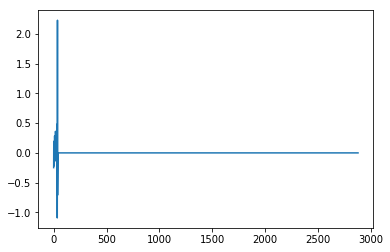

TypeError: Invalid dimensions for image data

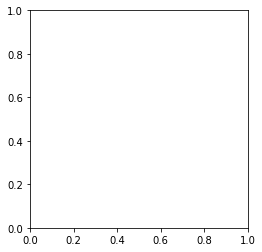

In [25]:
i = 4
_ = plt.plot(data[i,:].detach().numpy())
plt.show()
plt.imshow(data[i,:])
plt.show()
_ = plt.hist(data[i,:].detach().numpy().flatten(),31)

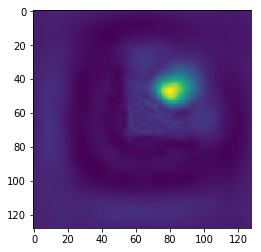

In [26]:
plt.imshow(retina.accuracy_invert(label[i,:].detach().numpy()))